In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Importation des valeurs

In [2]:
alpha = 0.15
b = 1
sigma = 0.2
T = 1
r = 0.05
K = 4
k = 20
dt = 1/20
S_0 = 5 #le fixer à 1 si on veut obtenir les cheveux 
nb_samples = 100

# Test du CIR 

In [3]:
import CIR

In [4]:
S = CIR.CIR(alpha, b, sigma, T, k, S_0)

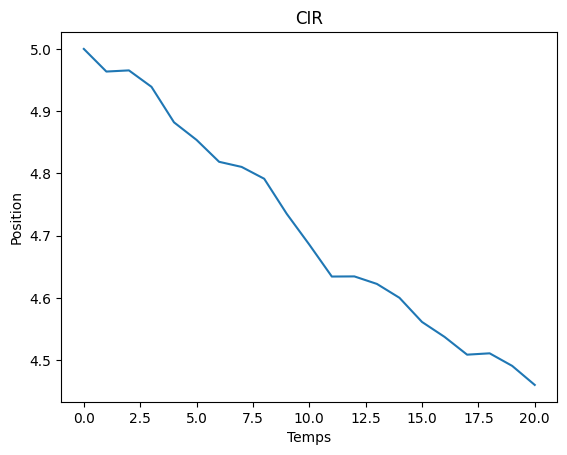

In [5]:
plt.plot(S)
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR')
plt.show()

In [6]:
nb_samples = 100

In [7]:
M = CIR.multiCIR(alpha, b, sigma, T, k, S_0, nb_samples)

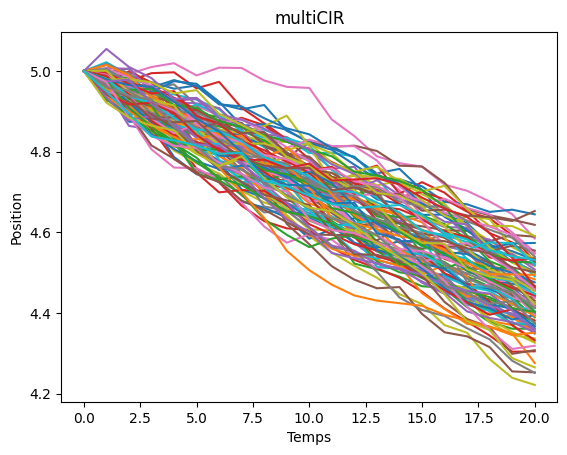

In [8]:
for i in range(nb_samples):
    plt.plot(M[i])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('multiCIR')
plt.show()

# Monte Carlo Ordinaire

In [9]:
import ordinaryMC

In [10]:
ordinaryMC.pv_calc(M[3],r, T)

array([4.75614712, 4.71957851, 4.72149418, 4.66096443, 4.59728074,
       4.52608841, 4.49354523, 4.43874137, 4.40222841, 4.38526463,
       4.38104683, 4.33978128, 4.31101694, 4.2910042 , 4.26856498,
       4.23574835, 4.1957816 , 4.16504935, 4.13235378, 4.09419452,
       4.09514785])

In [11]:
OMC = ordinaryMC.ordinary_mc_sim(nb_samples, k, S_0, T, r, sigma, K, alpha, b)

In [12]:
np.mean(OMC)

0.6836771147482481

In [13]:
ordinaryMC.sim_iterator(1000, k, S_0, T, r, sigma, K, alpha, b)

(array([0.68197958, 0.67289291, 0.67846731, 0.6765276 , 0.67800522,
        0.66990051, 0.67676194, 0.68255164, 0.67721586, 0.67655242,
        0.67992928, 0.67953737, 0.68384716, 0.67385228, 0.67756435,
        0.68541193, 0.67532974, 0.67748227, 0.68511391, 0.6777156 ,
        0.67431695, 0.6764799 , 0.67716861, 0.67778101, 0.68052216,
        0.68203109, 0.68073843, 0.67467841, 0.6840809 , 0.6720028 ,
        0.67976812, 0.68332401, 0.67811291, 0.6751226 , 0.6735403 ,
        0.67975869, 0.68075272, 0.67431785, 0.67735076, 0.67674573,
        0.67794607, 0.6783379 , 0.68169116, 0.67815999, 0.67984505,
        0.67419602, 0.68055897, 0.67444835, 0.67903638, 0.68061902,
        0.67430356, 0.68157279, 0.67706176, 0.68242974, 0.67941614,
        0.67987355, 0.6815399 , 0.67850629, 0.6745442 , 0.67897228,
        0.68105757, 0.67959092, 0.67808709, 0.67609867, 0.68055989,
        0.67893745, 0.67835714, 0.67513543, 0.68081081, 0.68047925,
        0.68155212, 0.67654395, 0.68018462, 0.67

# Comparaison Monte Carlo

In [14]:
max_sample = 1000

In [15]:
ordinaryMC_price_esitmates, ordinaryMC_CIs = ordinaryMC.sim_iterator(max_sample, k, S_0, T, r, sigma, K, alpha, b)



Price estimated at largest sample size with ordinary MC: 0.6766485940666651
CI length at largest sample size with ordinary MC: 0.006414421736482101


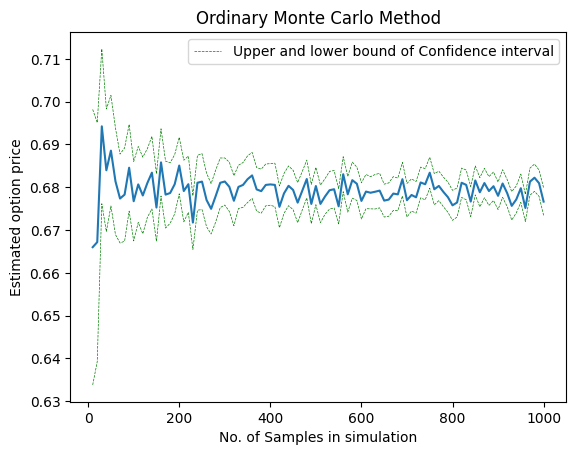

In [16]:
print("Price estimated at largest sample size with ordinary MC:", str(ordinaryMC_price_esitmates[-1]))
print("CI length at largest sample size with ordinary MC:", str(ordinaryMC_CIs[-1,1] - ordinaryMC_CIs[-1,0]))

#Ploting ordinary Monte Carlo method
x_axis1 = range(10, max_sample + 1, 10)
plt.plot(x_axis1, ordinaryMC_price_esitmates)
plt.plot(x_axis1, ordinaryMC_CIs[1:, 0], 'g--', lw=0.5, label='Upper and lower bound of Confidence interval')
plt.plot(x_axis1, ordinaryMC_CIs[1:, 1], 'g--', lw=0.5)
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option price")
plt.title("Ordinary Monte Carlo Method")
plt.legend()
plt.show()


In [17]:
import comparaison

In [18]:
CI = ordinaryMC_CIs
tol = 0.005
mc_threshold = comparaison.threshold_finder(CI, tol)
#sample_convergent = mc_threshold * 10
sample_convergent = 1500



In [19]:
CPU_sample = comparaison.CPU(sample_convergent,k, S_0, T, r, sigma, K, alpha, b)
CPU_sample


0.4520438500039745

In [20]:
mean_pv_payoffs_cvg = 0.6789593446701989

In [21]:

mse_comparaison = comparaison.mse_comparaison(100, k, S_0, T, r, sigma, K, alpha, b, 0.6789593446701989)

10
20
30
40
50
60
70
80
90
100


In [22]:
mse_comparaison
# Je ne comprends pas pourquoi je trouve ce résultat, je ne suis pas censé obtenir ça

[array([0.00337534, 0.00168246, 0.00159012, 0.00269638, 0.00272247,
        0.00276572, 0.00258261, 0.00317094, 0.00309303, 0.00336315]),
 0.0015901172152891808,
 2]

# Quasi Monte Carlo

# tests Sobol generator

In [23]:
nb_samples = 100

In [24]:
sobol = CIR.sobol_generator(nb_samples, k)
print(sobol, len(sobol), len(sobol[1,]))

[[0.5     0.75    0.25    ... 0.84375 0.34375 0.46875]
 [0.5     0.25    0.75    ... 0.21875 0.71875 0.09375]
 [0.5     0.75    0.25    ... 0.09375 0.59375 0.46875]
 ...
 [0.75    0.25    0.875   ... 0.53125 0.15625 0.65625]
 [0.75    0.25    0.375   ... 0.09375 0.21875 0.71875]
 [0.75    0.25    0.125   ... 0.78125 0.65625 0.15625]] 117 20


# tests CIR_QMC

In [25]:
M = CIR.multiCIR_QMC(alpha, b, sigma, T, k, S_0, nb_samples)

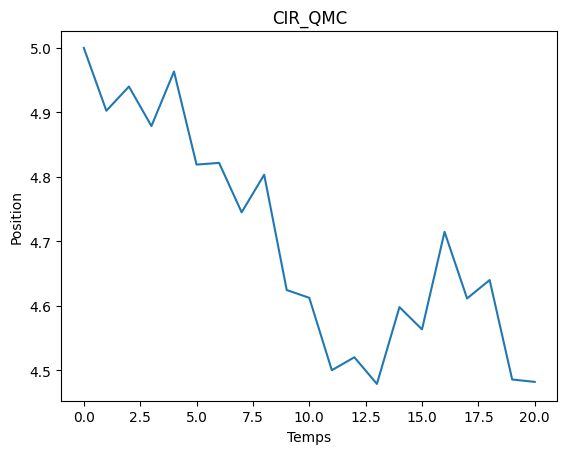

In [26]:
plt.plot(M[1])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR_QMC')
plt.show()

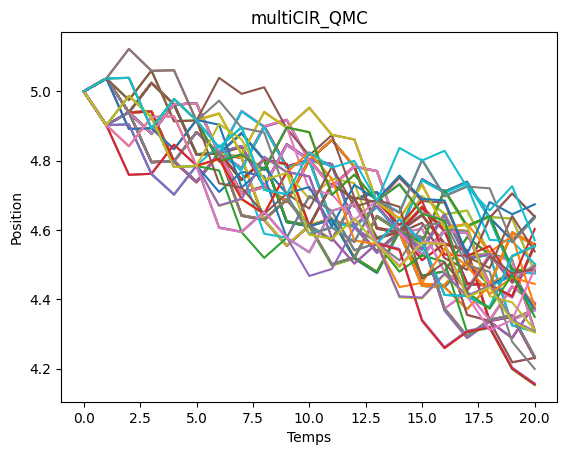

In [27]:
for i in range(nb_samples):
    plt.plot(M[i])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('multiCIR_QMC')
plt.show()

# Quasi Monte Carlos

In [28]:
import ordinaryMC
import QMC

In [29]:
ordinaryMC.pv_calc(M[3],r, T)

array([4.75614712, 4.66345079, 4.69914028, 4.56226408, 4.56486702,
       4.50807057, 4.58792692, 4.60631592, 4.49585464, 4.61115062,
       4.56896722, 4.55650063, 4.38662669, 4.44190474, 4.37079301,
       4.3235163 , 4.41775917, 4.2991677 , 4.31043676, 4.23279869,
       4.27786066])

In [30]:
OMC_QMC = QMC.QMC_mc_sim(nb_samples, k, S_0, T, r, sigma, K, alpha, b)
np.mean(OMC_QMC)

0.6729958803021122

In [31]:
QMC.sim_iterator_QMC(1000, k, S_0, T, r, sigma, K, alpha, b)

(array([0.67030405, 0.66890891, 0.67289144, 0.67368627, 0.67307766,
        0.67222133, 0.67397267, 0.67343756, 0.67302825, 0.67299588,
        0.67232377, 0.67187278, 0.67152841, 0.67126818, 0.67215052,
        0.67281187, 0.67259377, 0.67073935, 0.67169282, 0.67153946,
        0.67227589, 0.67190686, 0.67178969, 0.67184999, 0.67205816,
        0.67217644, 0.67262645, 0.67164796, 0.67172295, 0.67181705,
        0.67182892, 0.67229061, 0.6728063 , 0.67348223, 0.67445719,
        0.67504915, 0.67634998, 0.67519357, 0.67572613, 0.6758411 ,
        0.67625629, 0.67650668, 0.67647068, 0.6763089 , 0.67627988,
        0.67621747, 0.67684416, 0.67628533, 0.67630456, 0.67596895,
        0.67577944, 0.67526663, 0.6755823 , 0.67539858, 0.67540742,
        0.67461142, 0.67503888, 0.67527696, 0.67473238, 0.67455601,
        0.67449193, 0.67466979, 0.67458252, 0.67376248, 0.67401107,
        0.67360358, 0.67293898, 0.67269142, 0.67246486, 0.67160056,
        0.67168216, 0.67152864, 0.67133645, 0.67

# Comparaison QMC

In [32]:
max_sample = 1000


sobol_price_esitmates, sobol_CIs = QMC.sim_iterator_QMC(max_sample, k, S_0, T, r, sigma, K, alpha, b)

In [33]:
print("Price estimated at largest sample size with Sobol sequence:", str(sobol_price_esitmates[-1]))
print("CI length at largest sample size with Sobol sequence:", str(sobol_CIs[-1,1] - sobol_CIs[-1,0]))


Price estimated at largest sample size with Sobol sequence: 0.672063980448986
CI length at largest sample size with Sobol sequence: 0.009965255969321296


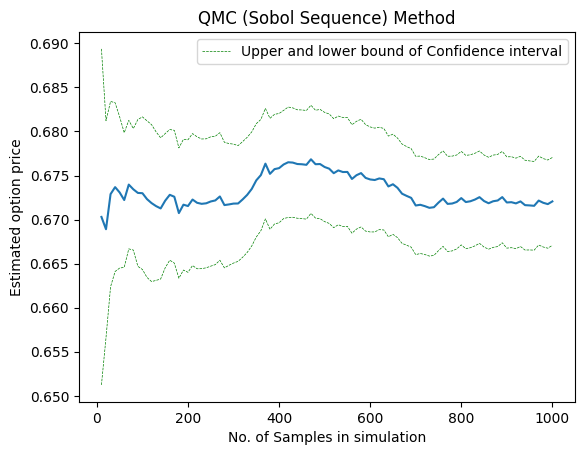

In [34]:
#Ploting quasi-Monte Carlo method using Sobol sequence

plt.plot(x_axis1, sobol_price_esitmates)
plt.plot(x_axis1, sobol_CIs[1:, 0], 'g--', lw=0.5, label='Upper and lower bound of Confidence interval')
plt.plot(x_axis1, sobol_CIs[1:, 1], 'g--', lw=0.5)
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option price")
plt.title("QMC (Sobol Sequence) Method")
plt.legend()
plt.show()

In [35]:
tol = 0.01
sobol_threshold = comparaison.threshold_finder(sobol_CIs, tol)

99


In [36]:
sample_convergent_QMC = sobol_threshold * 10

In [37]:
CPU_sample_QMC = comparaison.CPU(sample_convergent_QMC,k, S_0, T, r, sigma, K, alpha, b)
CPU_sample_QMC

0.10870905000774655

In [38]:
mse_comparaison = comparaison.mse_comparaison(100, k, S_0, T, r, sigma, K, alpha, b, 0.6789593446701989)

10
20
30
40
50
60
70
80
90
100


# tests Multi Level CIR

In [39]:
import CIR

In [40]:
L = 4

In [41]:
S = CIR.level_CIR(alpha, b, sigma, L, T, S_0)

In [42]:
S

array([5.        , 4.96049442, 4.9348886 , 4.90126323, 4.87353654,
       4.85156321, 4.8150548 , 4.77790766, 4.74342095, 4.70673894,
       4.66468003, 4.61867689, 4.58961395, 4.54901973, 4.52450081,
       4.48093969, 4.45230268])

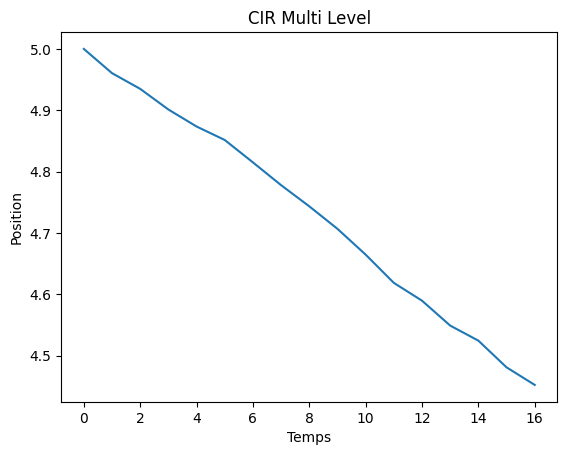

In [43]:
plt.plot(S)
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR Multi Level')
plt.show()

In [44]:
nb_samples = 100 

In [45]:
M = CIR.multiCIR_ML(alpha, b, sigma, L, T, S_0, nb_samples)

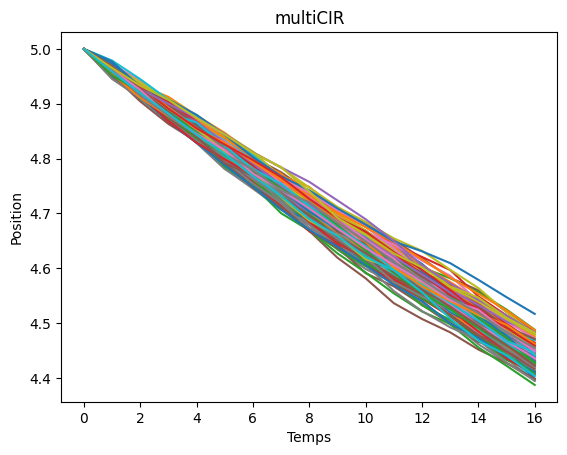

In [46]:
for i in range(nb_samples):
    plt.plot(M[i])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('multiCIR')
plt.show()

In [47]:
zap = CIR.CIR(alpha, b, sigma, T, k, S_0)
zap2 = CIR.CIR_ML(alpha, b, sigma, T, k, S_0,5)

AttributeError: module 'CIR' has no attribute 'CIR_ML'

In [ ]:
zap

array([1000.        ,  992.24149871,  984.29460658,  976.4068157 ,
        969.7423737 ,  962.11966941,  955.15628873,  948.34192344,
        941.38141745,  934.27450366,  927.43665843,  920.86286667,
        913.99932066,  907.45439369,  900.39086413,  893.23754233,
        886.9179914 ,  880.09466744,  872.84344813,  866.017522  ,
        859.98945129])

In [ ]:
zap2

array([1000.        ,  990.46117392,  981.39982838,  971.68914217,
        962.85992471,  953.91998516,  944.74041551,  935.56966166,
        926.50960883,  917.71959879,  908.92410262,  900.20829462,
        891.47485445,  882.91834458,  875.56105974,  867.225721  ,
        859.17785251,  851.25730492,  843.06987932,  835.17311589,
        827.94049722])

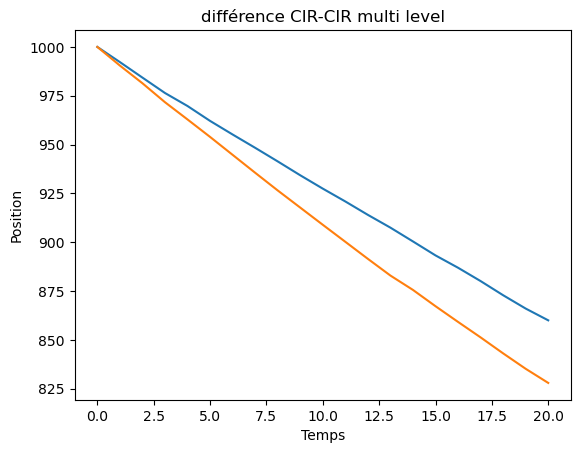

In [ ]:
plt.plot(zap)
plt.plot(zap2)
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('différence CIR-CIR multi level')
plt.show()

# Multi Level Monte Carlo

In [ ]:
import MLMC

In [ ]:
import CIR

In [ ]:
L = 10

In [ ]:
MLMC.level_mc_sim(nb_samples, S_0, T, r, sigma, K, alpha, b, L)

0.6795832819110003

In [ ]:
multiCIR_test = CIR.multiCIR_ML(alpha, b, sigma, L, T, S_0, nb_samples)

In [ ]:
MLMC.mc_telescopic_sum(alpha, b, sigma, L, T, S_0, nb_samples, r, K)

coucou


0.6469375713746368

In [ ]:
MLMC_test = MLMC.sim_MLMC(k, S_0, T, r, sigma, K, alpha, b)

Le ordinary tu fais n fois avec la même dicrétisation alors que le multi level tu fais n fois mais avec des discrétisations de plus en plus fines. Et en plus c'est "gratuit" car on utilise le même mouvement brownien.